In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import sqlite3
import pickle
from google.colab import drive
from IPython.display import display, Image
import io

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# TRÍCH  XUẤT ĐẶC TRƯNG VÀ LƯU VÀO DATABASE

In [ ]:
# Kết nối đến cơ sở dữ liệu SQLite
conn = sqlite3.connect('/content/drive/MyDrive/CS336/features.db')
cursor = conn.cursor()

In [ ]:
# Tạo bảng để lưu trữ đặc trưng
cursor.execute('''
    CREATE TABLE IF NOT EXISTS features (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        filepath TEXT NOT NULL,
        label TEXT NOT NULL,
        feature BLOB NOT NULL
    )
''')
conn.commit()

In [ ]:
def extract_and_save_feature(image_path, label):
    model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Đọc và preprocess ảnh
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = preprocess_input(image)

    # Lấy đặc trưng từ mô hình
    feature = model.predict(np.expand_dims(image, axis=0)).flatten()

    # Lưu vào SQLite
    cursor.execute('INSERT INTO features (filepath, label, feature) VALUES (?, ?, ?)', (image_path, label, pickle.dumps(feature)))
    conn.commit()

In [ ]:
# Thay đổi đường dẫn đến dataset
dataset_path = '/content/drive/MyDrive/CS336/data_manual/Images'

In [ ]:
# Lấy và lưu đặc trưng cho tất cả ảnh trong dataset
for label in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label)

    if os.path.isdir(label_path):
        for filename in os.listdir(label_path):
            filepath = os.path.join(label_path, filename)
            extract_and_save_feature(filepath, label)

1/1 [==============================] - 1s 867ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 920ms/step


In [ ]:
# Đóng kết nối đến SQLite
conn.close()

# TÍNH ĐỘ TƯƠNG ĐỒNG VÀ TÌM ẢNH TƯƠNG TỰ ĐẦU VÀO

In [ ]:
def calculate_cosine_similarity(feature1, feature2):
    dot_product = np.dot(feature1, feature2)
    norm_feature1 = np.linalg.norm(feature1)
    norm_feature2 = np.linalg.norm(feature2)
    similarity = dot_product / (norm_feature1 * norm_feature2)
    return similarity

In [ ]:
def find_similar_image(query_feature, top_n=5):
    conn = sqlite3.connect('/content/drive/MyDrive/CS336/features.db')
    cursor = conn.cursor()

    # Lấy đặc trưng của tất cả ảnh trong database
    cursor.execute('SELECT filepath, label, feature FROM features')
    rows = cursor.fetchall()

    # Tính toán độ tương đồng và lấy top n ảnh tương đồng
    similarities = []
    for row in rows:
        filepath, label, saved_feature = row
        saved_feature = pickle.loads(saved_feature)
        similarity = calculate_cosine_similarity(query_feature, saved_feature)
        similarities.append((filepath, label, similarity))

    # Sắp xếp theo độ tương đồng giảm dần
    similarities.sort(key=lambda x: x[2], reverse=True)

    # In ra top n ảnh tương đồng
    for i, (filepath, label, similarity) in enumerate(similarities[:top_n]):
        print(f"Top {i+1} Similar Image:")
        print(f" - Query Feature: {query_feature}")
        print(f" - Database Image: {filepath}")
        print(f" - Label: {label}")
        print(f" - Similarity: {similarity}")
        # Hiển thị ảnh
        image_data = open(filepath, "rb").read()
        image = Image(data=image_data, format='png')
        display(image)
        print("="*30)

    conn.close()

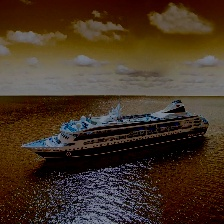

In [ ]:
# Đọc và preprocess ảnh truy vấn
query_image_path = '/content/ship.jpg'
query_image = cv2.imread(query_image_path)
query_image = cv2.resize(query_image, (224, 224))
query_image = preprocess_input(query_image)

# Hiển thị ảnh query
image_data = cv2.imencode('.jpg', query_image)[1].tobytes()
image = Image(data=image_data, format='jpeg')
display(image)

In [ ]:
# Lấy đặc trưng của ảnh truy vấn
query_feature = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)).predict(np.expand_dims(query_image, axis=0)).flatten()

1/1 [==============================] - 1s 882ms/step


Top 1 Similar Image:
 - Query Feature: [0.       0.       0.       ... 9.536173 0.       0.      ]
 - Database Image: /content/drive/MyDrive/CS336/data_manual/Images/ship/ship_03.png
 - Label: ship
 - Similarity: 0.4095034599304199


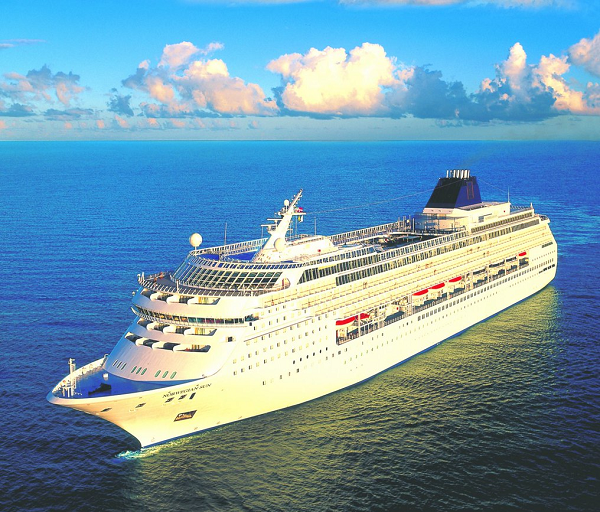

Top 2 Similar Image:
 - Query Feature: [0.       0.       0.       ... 9.536173 0.       0.      ]
 - Database Image: /content/drive/MyDrive/CS336/data_manual/Images/ship/ship_14.png
 - Label: ship
 - Similarity: 0.389946311712265


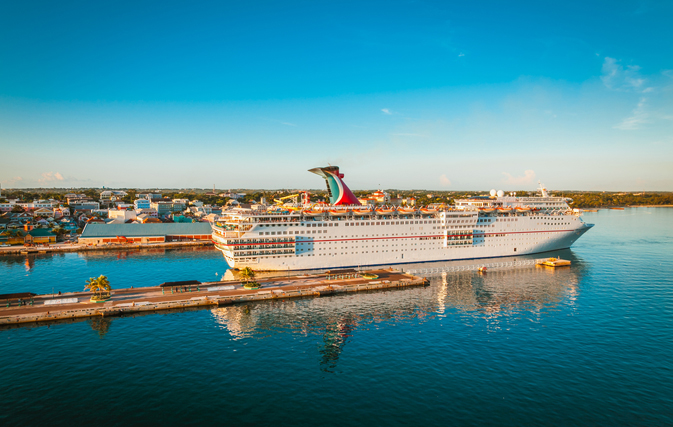

Top 3 Similar Image:
 - Query Feature: [0.       0.       0.       ... 9.536173 0.       0.      ]
 - Database Image: /content/drive/MyDrive/CS336/data_manual/Images/ship/ship_21.png
 - Label: ship
 - Similarity: 0.3503088653087616


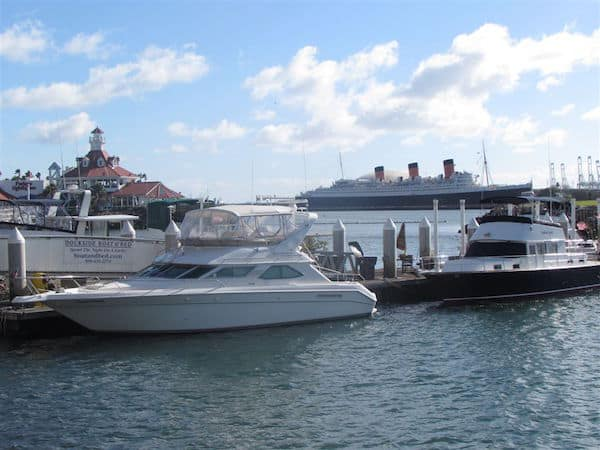

Top 4 Similar Image:
 - Query Feature: [0.       0.       0.       ... 9.536173 0.       0.      ]
 - Database Image: /content/drive/MyDrive/CS336/data_manual/Images/ship/ship_04.png
 - Label: ship
 - Similarity: 0.3235432207584381


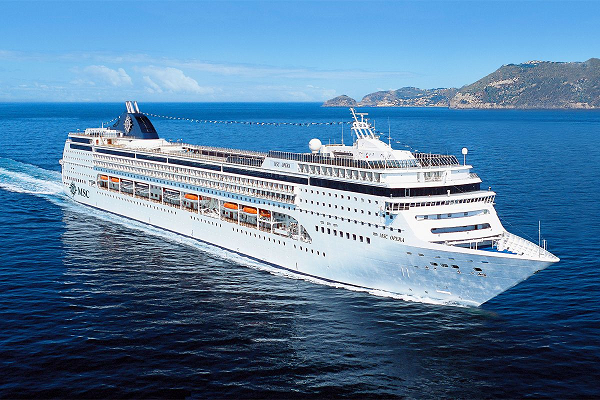

Top 5 Similar Image:
 - Query Feature: [0.       0.       0.       ... 9.536173 0.       0.      ]
 - Database Image: /content/drive/MyDrive/CS336/data_manual/Images/ship/ship_05.png
 - Label: ship
 - Similarity: 0.3162890076637268


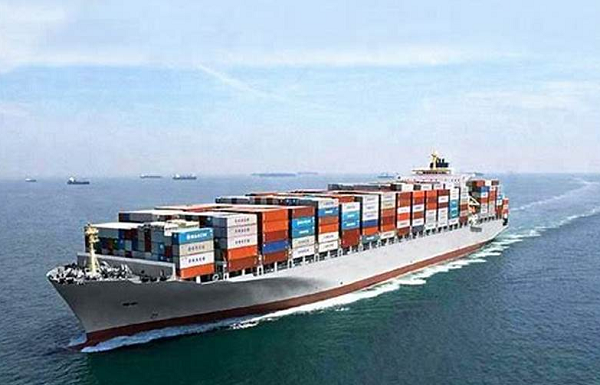

In [ ]:
# Tìm top 10 ảnh tương đồng
find_similar_image(query_feature)